In [81]:
import pandas as pd
import numpy as np

import re

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
stopwords = stopwords.words('english')


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression as log 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics    

import matplotlib.pyplot as plt

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dense, Input, Flatten

from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
import pandas as pd

from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv('labeled_lyrics_w_genres.csv')
df.head()

df = df.drop(columns = ['Unnamed: 0','Unnamed: 0.1'],axis = 1)

df_dropped = df[(df['genre'] == 'No_genre') | (df['genre'] == 'Non-Music')].index
df.drop(df_dropped, inplace=True, axis='index')

df['genre'].value_counts()

Pop        57357
Rock       26756
Country     7440
Rap         5959
R&B         4773
Name: genre, dtype: int64

In [4]:
df_balanced = ""

cond = df['genre'] == 'Pop'
df_pop = df[cond]
df_pop = df_pop[0:4000]

cond = df['genre'] == 'Rock'
df_rock = df[cond]
df_rock = df_rock[0:4000]
df_rock.shape

cond = df['genre'] == 'Country'
df_country = df[cond]
df_country = df_country[0:4000]
df_country.shape

cond = df['genre'] == 'Rap'
df_rap = df[cond]
df_rap = df_rap[0:4000]
df_rap.shape

cond = df['genre'] == 'R&B'
df_r_b = df[cond]
df_r_b = df_r_b[0:4000]
df_r_b.shape

(4000, 5)

In [5]:
df_balanced = pd.concat([df_pop, df_rock, df_country, df_rap, df_r_b], axis = 0)

df_balanced['genre'].value_counts()

Pop        4000
Rock       4000
Country    4000
Rap        4000
R&B        4000
Name: genre, dtype: int64

In [7]:
#Remove numbers
def remove_numbers(input):
    input = word_tokenize(input)
    without_sw = [word for word in input 
                  if word.isalpha()]
    return ' '.join(without_sw)

# 1. function that makes all text lowercase.
def make_lowercase(test_string):
    return test_string.lower()

# 2. function that removes all punctuation. 
def remove_punc(test_string):
    test_string = re.sub(r'[^\w\s]', '', test_string)
    return test_string

# 3. function that removes all stopwords.
def remove_sw(input):
    input = word_tokenize(input)
    without_sw = [word for word in input 
                  if word not in stopwords]
    return ' '.join(without_sw)

# 4. function to break words into their stem words
def stem_words(input):
    stemming = PorterStemmer()
    tokenized_words = word_tokenize(input)
    
    stemmed_words = [stemming.stem(word) for word in tokenized_words]
    return ' '.join(stemmed_words)

In [8]:
# Pipeline

def text_processing_pipeline(a_string):
    a_string = make_lowercase(a_string)
    a_string = remove_numbers(a_string)
    a_string = remove_punc(a_string)
    a_string = remove_sw(a_string)
    #a_string = stem_words(a_string)
    return a_string

In [9]:
df_balanced['seq_clean'] = df_balanced['seq'].apply(lambda x: text_processing_pipeline(x))

In [56]:
df_balanced.head()

,artist,seq,song,label,genre,seq_clean
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630,Pop,drinks go smoke goes feel got let go cares get...
7,Elis,Dieses ist lange her.\r\nDa ich deine schmalen...,Abendlied,0.333,Pop,dieses ist lange da ich deine schmalen hande n...
8,Elis,A child is born\r\nOut of the womb of a mother...,Child,0.506,Pop,child born womb mother want happened night dru...
9,Elis,Out of the darkness you came \r\nYou looked so...,Come to Me,0.179,Pop,darkness came looked tired sad asked answered ...
10,Elis,Each night I lie in my bed \r\nAnd I think abo...,Do You Believe,0.209,Pop,night lie bed think oh dark friend give answer...


In [20]:
X = df_balanced.seq_clean.apply(lambda x: word_tokenize(x))

In [21]:
len(X)

20000

In [22]:
word2vec_model = Word2Vec(X, vector_size = 250, sg=1, workers=4)

In [23]:
word2vec_model.train(X, total_examples=20000, epochs=100)

(248207082, 281636700)

In [24]:
word2vec_model.save("word2vec.model")

In [43]:
word2vec_model.wv.most_similar(positive ='country')

[('blaring', 0.3584658205509186),
 ('outshine', 0.33836624026298523),
 ('tater', 0.33717799186706543),
 ('maddening', 0.33615100383758545),
 ('egypt', 0.3255713880062103),
 ('plantin', 0.32503318786621094),
 ('twang', 0.3224688768386841),
 ('password', 0.31763532757759094),
 ('allowing', 0.3130062222480774),
 ('geordie', 0.3123916983604431)]

In [30]:
w2v_words = list(word2vec_model.wv.key_to_index)

In [42]:
word2vec_model.vector_size

250

In [45]:
w2v_words = list(word2vec_model.wv.key_to_index)
def lyric_vector(tokens, size):
    sent = np.zeros(250)
    count = 0
    for word in tokens:
        if word in w2v_words:
            vec = word2vec_model.wv[word]
            sent += vec
            count += 1
    if count != 0:
        sent /= count
    return sent

In [46]:
vector = []
for sent in X:
    sentence = lyric_vector(sent, 200)
    vector.append(sentence)

In [48]:
lyric_vector = pd.DataFrame(vector)
lyric_vector['genre'] = pd.DataFrame(df['genre'])
lyric_vector.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,genre
0,-0.003442,-0.009845,0.033642,0.017867,-0.108870,0.080865,-0.016341,0.127219,-0.008023,0.064092,...,-0.080286,-0.046972,0.109665,-0.070063,0.022983,0.204102,-0.211368,0.015924,0.075099,R&B
1,0.255161,0.016113,-0.141956,0.126649,-0.660588,0.432395,0.049746,0.324717,0.276112,0.297900,...,-0.490461,-0.639241,-0.026243,0.107472,0.516244,0.618618,-0.852951,-0.224987,0.202187,Pop
2,0.059246,0.086929,-0.028027,0.117113,-0.130827,0.086468,0.168874,0.176982,0.040304,0.100041,...,-0.144587,0.103171,0.063966,-0.039830,-0.011357,0.169608,-0.010939,0.126084,-0.156405,R&B
3,0.040458,0.007651,0.085805,0.007954,-0.076782,0.055943,0.112457,-0.001349,0.048217,-0.027759,...,-0.080867,0.081536,0.005493,-0.018395,0.039758,0.277116,-0.085474,-0.048438,0.066239,R&B
4,0.079064,-0.127495,-0.035198,0.046875,-0.217552,0.071098,0.105536,0.128783,0.083611,-0.024084,...,-0.098803,-0.053946,0.058641,0.017946,-0.015124,0.246829,-0.046775,-0.025265,0.057481,R&B


In [ ]:
df['genre']

In [69]:
from sklearn.preprocessing import LabelEncoder
df = df_balanced.sample(frac=1)
labelencoder = LabelEncoder()
df['genre'] = labelencoder.fit_transform(df['genre'])

In [70]:
X = df['seq_clean']

y = df['genre'].values

y = to_categorical( y )
X_text = X

In [74]:
# Limiting our tokenizers vocab size
max_words = 25000

# create the tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit the tokenizer
tokenizer.fit_on_texts(X)

# Create the sequences for each sentence, basically turning each word into its index position
sequences = tokenizer.texts_to_sequences(X)

index_word = tokenizer.index_word

# # Limiting our sequence to only include 500 words
max_length = 500

# # Convert the sequences to all be the same length of 500
X = pad_sequences(sequences, maxlen=max_length, padding='post')

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [78]:
# This creates the Neural Network
model = Sequential() 

# This embedding layer basically will automatically create the word2vec vectors based on your text data.
model.add( Embedding(max_words, 32, input_length=max_length) ) 


model.add(Flatten())

model.add(Dense(128, activation='relu'))


model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           800000    
                                                                 
 flatten_1 (Flatten)         (None, 16000)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2048128   
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,848,773
Trainable params: 2,848,773
Non-trainable params: 0
_________________________________________________________________


In [79]:
hist = model.fit(X, y, 
                 validation_split=0.2, 
                 epochs=20, batch_size=20)

Epoch 1/20
800/800 [==============================] - 18s 22ms/step - loss: 1.1922 - accuracy: 0.4863 - val_loss: 1.0873 - val_accuracy: 0.5610
Epoch 2/20
800/800 [==============================] - 16s 20ms/step - loss: 0.6754 - accuracy: 0.7466 - val_loss: 1.2162 - val_accuracy: 0.5282
Epoch 3/20
800/800 [==============================] - 17s 21ms/step - loss: 0.1883 - accuracy: 0.9463 - val_loss: 1.6325 - val_accuracy: 0.5165
Epoch 4/20
800/800 [==============================] - 16s 20ms/step - loss: 0.0678 - accuracy: 0.9852 - val_loss: 1.7948 - val_accuracy: 0.5153
Epoch 5/20
800/800 [==============================] - 16s 21ms/step - loss: 0.0431 - accuracy: 0.9892 - val_loss: 1.9694 - val_accuracy: 0.5120
Epoch 6/20
800/800 [==============================] - 17s 21ms/step - loss: 0.0295 - accuracy: 0.9914 - val_loss: 2.2023 - val_accuracy: 0.5002
Epoch 7/20
800/800 [==============================] - 16s 20ms/step - loss: 0.0252 - accuracy: 0.9916 - val_loss: 2.1691 - val_accuracy:

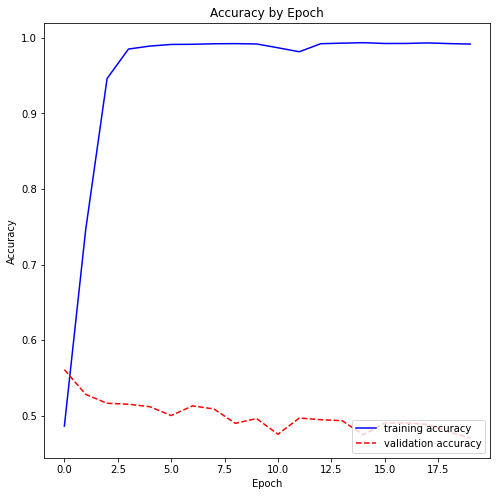

In [84]:
# plot the acccuracy

plt.figure(figsize=(8,8))
plt.plot(hist.history['accuracy'], label='training accuracy',color='blue')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy',color='red', linestyle='dashed')
plt.title('Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.9, 1.1])
plt.legend(loc='lower right')

# RNN Using LSTM

In [99]:
#Create LSTM model
from tensorflow.keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Embedding(max_words, 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           800000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 825,157
Trainable params: 825,157
Non-trainable params: 0
_________________________________________________________________


In [100]:
loss='categorical_crossentropy'
optimizer='adam'
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics) 

In [101]:
model.fit(X, y, validation_split=0.2, 
                 epochs=20, batch_size=20)

Epoch 1/20
800/800 [==============================] - 97s 120ms/step - loss: 1.6102 - accuracy: 0.2046 - val_loss: 1.6100 - val_accuracy: 0.1963
Epoch 2/20
800/800 [==============================] - 103s 129ms/step - loss: 1.6141 - accuracy: 0.1999 - val_loss: 1.6151 - val_accuracy: 0.1963
Epoch 3/20
800/800 [==============================] - 122s 152ms/step - loss: 1.6110 - accuracy: 0.2021 - val_loss: 1.6123 - val_accuracy: 0.2085
Epoch 4/20
800/800 [==============================] - 146s 183ms/step - loss: 1.6059 - accuracy: 0.2039 - val_loss: 1.6034 - val_accuracy: 0.2163
Epoch 5/20
800/800 [==============================] - 129s 162ms/step - loss: 1.6062 - accuracy: 0.2006 - val_loss: 1.6043 - val_accuracy: 0.2040
Epoch 6/20
800/800 [==============================] - 153s 192ms/step - loss: 1.6155 - accuracy: 0.1980 - val_loss: 1.6052 - val_accuracy: 0.2165
Epoch 7/20
800/800 [==============================] - 136s 170ms/step - loss: 1.5965 - accuracy: 0.2161 - val_loss: 1.4403 - 

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)